In [1]:
# Import libraries
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
# load data
dfy = pd.read_csv("labels.csv")
y = []
for val in range(dfy.shape[0]):
    y.append(dfy.iloc[val][1])
y = np.asarray(y)

dfx = pd.read_csv("vec_text.csv")
dfx = dfx.drop('index', 1)
X = []
for row in range(dfx.shape[0]):
    vec = []
    for val in dfx.iloc[row]:
        vec.append(val)
    X.append(vec)
X = np.asarray(X)
print(y.shape,X.shape)

(91726,) (91726, 1000)


In [3]:
pd.concat([dfx, dfy.reindex(dfx.index)], axis=1)

0  1  2  3  4  5  6  7  8  9  ...  992  993  994  995  996  997  998  \
0      0  0  0  0  0  1  1  0  0  1  ...    0    0    0    0    0    0    0   
1      0  0  0  0  0  1  1  0  0  0  ...    0    0    0    0    0    0    0   
2      1  0  0  0  0  1  0  1  0  1  ...    0    0    0    0    0    0    0   
3      1  0  0  0  0  0  0  1  0  0  ...    0    0    0    0    0    0    0   
4      0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
...   .. .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...  ...  ...  ...   
91721  0  1  1  0  1  1  1  0  1  1  ...    0    0    0    0    0    0    0   
91722  0  1  1  0  1  1  1  0  1  1  ...    0    0    0    0    0    0    0   
91723  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
91724  0  1  0  0  1  1  0  0  1  1  ...    0    0    1    0    0    0    0   
91725  0  1  0  0  1  1  0  1  0  1  ...    0    0    1    0    0    0    0   

       999  Unnamed: 0         0  
0        0           0    Trader  
1        0           1    Trader  
2        0           2    Trader  
3        0           3    Trader  
4        0           4    Trader  
...    ...         ...       ...  
91721    0       91721   Manager  
91722    0       91722  Employee  
91723    0       91723   Manager  
91724    0       91724  Employee  
91725    0       91725   Manager  

[91726 rows x 1002 columns]

In [4]:
# preprocess y data to categories
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
Y = one_hot_encode(y)
Y.shape
print(Y[5].dtype)
tf.__version__

float64


'2.1.0'

In [5]:
# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(500, activation='relu'))
# Add another:
model.add(layers.Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

In [6]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=METRICS)

In [7]:
# train model
history = model.fit(X, Y, epochs=20, validation_split=0.3, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

Train on 64208 samples, validate on 27518 samples
Epoch 1/20
64208/64208 [==============================] - 15s 233us/sample - loss: 4.5380 - tp: 30835.0000 - fp: 7872.0000 - tn: 570000.0000 - fn: 33373.0000 - accuracy: 0.9358 - precision: 0.7966 - recall: 0.4802 - auc: 0.9269 - val_loss: 5.0731 - val_tp: 5444.0000 - val_fp: 7431.0000 - val_tn: 240231.0000 - val_fn: 22074.0000 - val_accuracy: 0.8928 - val_precision: 0.4228 - val_recall: 0.1978 - val_auc: 0.7891
Epoch 2/20
64208/64208 [==============================] - 13s 204us/sample - loss: 3.9583 - tp: 38743.0000 - fp: 7738.0000 - tn: 570134.0000 - fn: 25465.0000 - accuracy: 0.9483 - precision: 0.8335 - recall: 0.6034 - auc: 0.9532 - val_loss: 5.2464 - val_tp: 5693.0000 - val_fp: 8183.0000 - val_tn: 239479.0000 - val_fn: 21825.0000 - val_accuracy: 0.8910 - val_precision: 0.4103 - val_recall: 0.2069 - val_auc: 0.7769
Epoch 3/20
64208/64208 [==============================] - 13s 209us/sample - loss: 3.8778 - tp: 42535.0000 - fp: 6883.

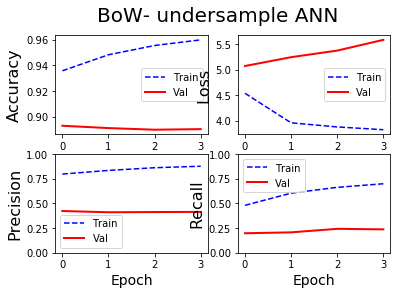

In [8]:
figName = "BoW- undersample ANN"

metrics =  ['accuracy', 'loss', 'precision', 'recall']
fig = plt.figure()
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    plt.ylabel(name, fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')